## Dual Momentum Portfolio
This Notebook is designed to show a simple system which loops through daily data on three instruments: a stock, a bond and cash. Momentum is measured by a moving average crossover. The system invests in stocks if the short moving avearge of the stock's price is above the long moving average. If the stock momentum indicator shows no trend but the bond short moving average is above the bond long moving average, the system invests in bonds. If the both stocks and bonds fail the momentum test, the system invests in cash.



## You will need to import the following Python packages into the Notebook

In [82]:
import datetime
import logging
import os
import sys
import ffn
from collections import OrderedDict
from typing import Dict, List
import numpy as np
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
%matplotlib notebook

## You may or may not find the following options useful.

In [83]:
pd.set_option("max_colwidth", 100)
pd.set_option("display.max_rows", 100000)
pd.set_option("display.max_columns", 1000)
pd.set_option('precision', 6)
pd.options.display.float_format = '{:20,.6f}'.format

## Set up the built in Python logging facilty
Useful for de-bugging.

Currently set to: logger.setLevel(logging.INFO)

Set this to DEBUG if you want some verbose output: logger.setLevel(logging.DEBUG)
    

In [84]:
logger = logging.getLogger("a_w")
logger.setLevel(logging.INFO)

# create a file handler
handler = logging.StreamHandler()
for handler in logger.handlers:
    logger.removeHandler(handler)
handler.setLevel(logging.DEBUG)

# create a logging format
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)

## Initialise Variables
Make sure to set the directory to where your stock data is located. 

Change dates, allocations and stocks as desired

In [85]:
start: datetime.date = '1900-01-01'
end = datetime.date.today()

starting_capital: float() =100000

stock_directory: str = '..\\data\\Stocks\\'

stock: str = 'WillshireTRFed'
#bond: str = 'Fed5YR'
bond: str = '30YrBond'
money:str = '3mTBill'


sma_length: int= 10
lma_length: int=20


stock_tickers_list: List[str] = [stock, bond,money]


#list of files to be saved. Ensure you use your own directories and desired filenames
test: str = "C:\\Users\\agarn\\OneDrive\\Documents\\Articles//DMtest.csv"
drawdown: str = "C:\\Users\\agarn\\OneDrive\\Documents\\Articles//DMdrawdown.csv"
rebased: str = "C:\\Users\\agarn\\OneDrive\\Documents\Articles//DMrebased.csv"
stats: str = "C:\\Users\\agarn\\OneDrive\\Documents\\Articles//DMstats.csv"




In [86]:
#This function will calculate the VAMI each day from the return for that day
@jit()
def calculator(a):
    res = np.empty(data.equity.shape)
    res[0] = 100
    for i in range(1, res.shape[0]):
        res[i] = res[i-1] +(res[i-1]* a[i])
    return res

## The following function checks to ensure the stock directory is correct and the data files exist:

In [87]:
def check_data_files(ticker_list: List, target_directory: str):
    logger = logging.getLogger("a_w.check_data_files")

    if not os.path.exists(stock_directory):
        logger.info('stockdirectory does not exist')
    for ticker in stock_tickers_list:
        filename = os.path.join(stock_directory, ticker + '.csv')
        if not os.path.exists(filename):
            logger.info('file does not exist in given directory:' + " " + ticker)

In [88]:
check_data_files(stock_tickers_list,stock_directory)

## The next function returns a dictionary of dataframes for the stock data:
Reads the desired files from the relevant directory

In [89]:
def get_dataframe_dictionary(ticker_list: List,
                             target_directory: str) -> Dict[str, pd.DataFrame]:
    """
    Get a list of files and put into a dictionary of dataframes
    :param ticker_list:
    :param target_directory:
    :return:
    """
    ret = OrderedDict()
    logger = logging.getLogger("a_w.get_dataframe_dictionary")
    logger.debug("get_dataframe_dictionary: %s", ticker_list)
    for ticker in ticker_list:
        filename = os.path.join(target_directory, ticker + '.csv')
        if os.path.exists(filename):
            try:
                ret[ticker] = pd.read_csv(filename, parse_dates=["Date"])
            except:
                continue
    return ret

## Merge the three separate time series into a single dataframe for back testing:

In [90]:
def merge_data(stock_tickers_list: List[str], target_directory: str,
               start: str, end: str) -> pd.DataFrame:
    """
    take the dicts of stocks time series and create a dataframe to pass for backtesting
    :param stock_tickers_list:
    :param start:  date like '2001-01-01' YYYY-MM-DD format
    :param end: date like '2001-12-31' YYYY-MM-DD format
    :return:
    """
    logger = logging.getLogger('a_w.merge_data')
    logger.debug("Running: stock_tickers_list: %d", len(stock_tickers_list))
    check_data_files(stock_tickers_list, target_directory)
    stock_data = get_dataframe_dictionary(stock_tickers_list, target_directory)
    logger.debug("Found Data: %d", len(stock_tickers_list))
    data = pd.DataFrame()

    for ticker in stock_tickers_list:
        try:
            if data.empty:
                data = stock_data[ticker]
            else:
                a = stock_data[ticker]
                data = data.merge(
                    a, how='left', left_on='Date',
                    right_on='Date').fillna(method='ffill')
                data = data.dropna()
        except:
            continue
    logger.debug("Cols:{}".format(data.columns.values))
    logger.debug("Now I have a datframe with shape: %s", data.shape)

    if not data.empty:
        new_index = pd.to_datetime(pd.Series(data['Date']))
        data.set_index(new_index,drop=True,append=False,inplace=True,verify_integrity=False)
        data.drop(['Date'], inplace=True, axis=1)
        data = data.truncate(before=start, after=end, axis=0)
    if len(data.columns) == 3:
        data.columns = ['stock', 'bond','money']
        data['stock_return']=data.stock.pct_change()
        data['bond_return']=data.bond.pct_change()
        data['money_return']=data.money.pct_change()
        data['stock_test']=data.stock.rolling(sma_length).mean().shift(2)>data.stock.rolling(lma_length).mean().shift(2)
        data['bond_test']=data.bond.rolling(sma_length).mean().shift(2)>data.bond.rolling(lma_length).mean().shift(2)
        conditions=[data.stock_test==True,(data.stock_test==False) & (data.bond_test==False),data.stock_test==False,]
        outputs=[data.stock_return,data.money_return,data.bond_return]
        data['strategy_return']=np.select(conditions, outputs)
        data.dropna(inplace=True)
        data['equity']=0.0
        #data['dual_momentum'] = calculator(*data[list(data.loc[:, ['strategy_return']])].values.T)
        

    return data[lma_length:]

## Call the functions listed so far and inspect the dataframe.

In [91]:
data=merge_data(stock_tickers_list, stock_directory,start,end)

In [92]:
inspect_data = pd.DataFrame()
if not data.empty:
    inspect_data = data
    #inspect_data.to_csv("C:\\Users\\agarn\\OneDrive\\Documents\Articles//DM_inspect_data.csv")   
else:
    print('data loading failed see logging')
inspect_data.head()

stock                 bond                money  \
Date                                                                        
1980-01-02             1.860000            29.500860           221.498467   
1980-01-04             1.880000            28.871750           221.645348   
1980-01-07             1.890000            28.557190           221.717368   
1980-01-08             1.930000            28.905450           221.788925   
1980-01-09             1.930000            29.141370           221.860383   

                   stock_return          bond_return         money_return  \
Date                                                                        
1980-01-02            -0.021053             0.005745             0.000333   
1980-01-04             0.010753            -0.021325             0.000663   
1980-01-07             0.005319            -0.010895             0.000325   
1980-01-08             0.021164             0.012195             0.000323   
1980-01-09             0.000000             0.008162             0.000322   

            stock_test  bond_test      strategy_return               equity  
Date                                                                         
1980-01-02        True      False            -0.021053             0.000000  
1980-01-04        True      False             0.010753             0.000000  
1980-01-07        True      False             0.005319             0.000000  
1980-01-08        True      False             0.021164             0.000000  
1980-01-09       False      False             0.000322             0.000000

In [93]:
data['equity'] = calculator(*data[list(data.loc[:, ['strategy_return']])].values.T)
data.head()

stock                 bond                money  \
Date                                                                        
1980-01-02             1.860000            29.500860           221.498467   
1980-01-04             1.880000            28.871750           221.645348   
1980-01-07             1.890000            28.557190           221.717368   
1980-01-08             1.930000            28.905450           221.788925   
1980-01-09             1.930000            29.141370           221.860383   

                   stock_return          bond_return         money_return  \
Date                                                                        
1980-01-02            -0.021053             0.005745             0.000333   
1980-01-04             0.010753            -0.021325             0.000663   
1980-01-07             0.005319            -0.010895             0.000325   
1980-01-08             0.021164             0.012195             0.000323   
1980-01-09             0.000000             0.008162             0.000322   

            stock_test  bond_test      strategy_return               equity  
Date                                                                         
1980-01-02        True      False            -0.021053           100.000000  
1980-01-04        True      False             0.010753           101.075269  
1980-01-07        True      False             0.005319           101.612903  
1980-01-08        True      False             0.021164           103.763441  
1980-01-09       False      False             0.000322           103.796873

## Save backtest data to file for further inspection. Use FFN package to create charts and statistics for the backtest.

In [94]:
 def show_stats(backtest: pd.DataFrame):
    if backtest is not None and not backtest.empty:
        logger = logging.getLogger('a_w.charts')
        res = backtest.equity.astype(np.float64)
        benchmarked = pd.concat(
            [res, backtest.stock, backtest.bond], sort=False, axis=1)   
        log = True
        benchmarked.rebase().plot(figsize=(7, 6), logy=log, title='All Weather Portfolio')
        benchmarked.calc_stats().display()
        benchmarked.to_drawdown_series().plot(figsize=(8, 6))

        def save_1():backtest.to_csv(test)
        def save_2():benchmarked.rebase().to_csv(rebased)
        def save_3():benchmarked.calc_stats().to_csv(sep=', ', path=stats)
        def save_4():benchmarked.to_drawdown_series().to_csv(drawdown)
        save_files=[save_1,save_2,save_3,save_4]
        for s in save_files:
            try:
                s()
            except IOError:
                print('file open - close file ',s)  
                continue

    else:
        print('backtest failed see logging')

## Call the show-backtest function

<IPython.core.display.Javascript object>


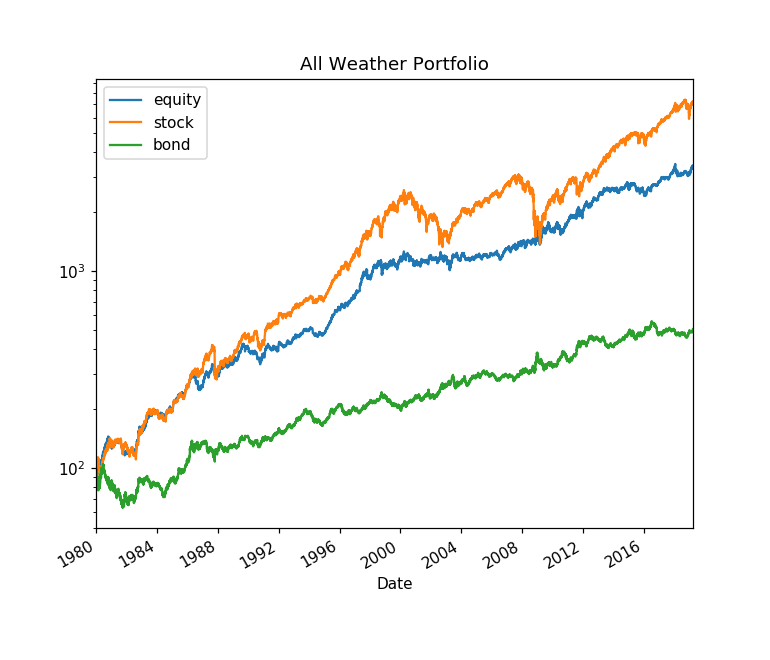

Stat                 equity      stock       bond
-------------------  ----------  ----------  ----------
Start                1980-01-02  1980-01-02  1980-01-02
End                  2019-03-29  2019-03-29  2019-03-29
Risk-free rate       0.00%       0.00%       0.00%

Total Return         3302.05%    7087.63%    407.82%
Daily Sharpe         0.81        0.73        0.41
Daily Sortino        1.27        1.14        0.68
CAGR                 9.41%       11.51%      4.23%
Max Drawdown         -21.39%     -55.39%     -39.66%
Calmar Ratio         0.44        0.21        0.11

MTD                  1.73%       1.50%       3.36%
3m                   9.81%       15.10%      3.72%
6m                   6.39%       -2.19%      7.49%
YTD                  9.36%       14.11%      3.29%
1Y                   9.19%       8.93%       4.89%
3Y (ann.)            9.57%       13.71%      -0.04%
5Y (ann.)            5.27%       10.53%      3.28%
10Y (ann.)           9.18%       16.16%      3.71%
Since Incep. 

<IPython.core.display.Javascript object>


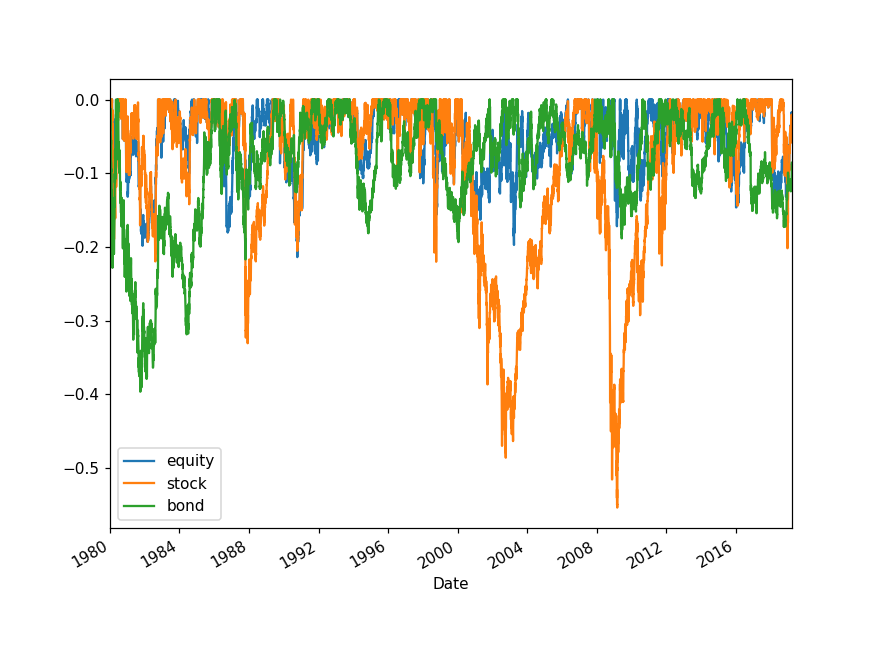

In [95]:
show_stats(data)

## This is my Python version
from platform import python_version

python_version()

'3.6.8'

## Anaconda Version and System Info

sys.version,sys.version_info

('3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]',
 sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0))

## Version of the Imports

import pip

%pip list

Package    Version 
---------------------------------- --------
ffn                                0.3.4    
numpy                              1.16.2     
pandas                             0.24.2  
   
